# Homework 2 

*Student: Dayana Valentina Gonzalez Vargas*

## Libraries

In [847]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import math

**1. Write down a code able to read the data that is attached and create a doubly-connected edge list for the simple polygon.**

## Doubly-connected edge list
### Main Classes

- **Class Vertex**

In [848]:
class vertex:
    def __init__(self, x , y, name):
        self.x = x ## Coordinate X
        self.y = y ## Coordinate Y
        self.name = name ## Name's vertex
        self.edge_inci = None ## Incident Edge
        self.type = None #Type vertex Start,end,regular,merge o split
        self.chain = None # Idicate the chain, if Right or Left

    ## Add Incident Edge
    def add_edge_inci(self,e):
        self.edge_inci = e

    ##Relation of order binary -> 0 below, -> 1 above.
    def r_order_binary(self,q):
        if self.y > q.y:
            return 0
        elif self.y == q.y:
            if self.x < q.x:
                return 0
            else:
                return 1
        else:
            return 1
    
    #Relation of order, Output: point
    def r_orden(self,q):
        if self.y > q.y:
            point = self
        elif self.y == q.y:
            if self.x < q.x:
                point = self
            else:
                point = q
        else:
            point = q
        return point


- **Class Edge**

In [849]:
class half_edge:
    def __init__(self,start,end,name):
        self.origin = start #Origin
        self.queue = end #Queue
        self.name = name #Name
        self.next = None #Next
        self.prev = None #Prev
        self.face = None #Incident Face
        self.twin_save = None  #Save Twin
        self.helper = None #Save Helper

    # Save Helper
    def update_helper(self,vi):
        self.helper =vi

    #General twin
    def coor_twin(self): #General Twin
        return self.queue, self.origin
    
    #Save Twin
    def add_twin_save(self,t):
        self.twin_save = t #Twin have to be object Edge
    
    def add_next(self,n):
        self.next = n #Next have to be object Edge
    
    def add_prev(self,pv):
        self.prev = pv #Prev have to be object Edge

    def add_face(self,f):
        self.face = f #Face have to be object Face  

    def add_twin(self,t):
          self.twin = t # Twin have to be object Edge

- **Class Face**

In [850]:
class face:
    def __init__(self,n):
        self.name = n #Name
        self.exterior = 'None' #External border
        self.interior = 'None' #Internal border

## we must take into account this fuction:
- Cross product
- Orientation

In [851]:
# P0 : Point prev origin
# P1 : Point edge origin
# P2 : Point next origin
def Producto_Cruz(P0,P1,P2):
    d = ((P1.x-P0.x)*(P2.y-P0.y))-((P2.x-P0.x)*(P1.y-P0.y))
    return d

In [852]:
# P0 : Point prev origin
# P1 : Point edge origin
# P2 : Point next origin
#Orientation
def orientacion(P0,P1,P2):
    d = Producto_Cruz(P0,P1,P2)
    if d>0:
        a = True
        #print("P2 se hace un giro en sentido horario de P1")
    else:
        a = False
        #print("P2 esta girando en sentido Anti horario de P1")
    return a 

## Class DCLE
For this class we will take into account the objects defined above, as well as concepts seen in class such as the following:


In [853]:
class DCEL():
    # We insert only the list object vertex
    def __init__(self,vertex):
        self.list_edge = []
        self.list_vertex = vertex
        self.list_face = []

    #----------------------------------------------------------------
    #Generate the twins with their characteristics
    def _add_twin(self):
        #Lists
        twins = []
        twins_sorted = []

        #General twins
        edges_copy = self.list_edge.copy()
        for i in range(len(edges_copy)):
            t_start, t_end = edges_copy[i].coor_twin()
            tn = half_edge(t_start,t_end,'te'+str(i+1))
            tn.add_twin_save(self.list_edge[i])
            twins.append(tn)

        #print('Entro2')
        
        # Organizamos para que quede de manera ciclica y agremaos el next
        origen = twins[0].queue
        a = True
        while(a != False):
            edge_next = [i for i in twins  if i.origin == origen]
            twins_sorted.append(edge_next[0])
            origen = edge_next[0].queue
            if len(twins_sorted) == len(twins):
                a = False


        index = len(self.list_edge) - len(twins_sorted)
        twin_Already = []
        # Add Next and Prev
        for i in range(0,len(twins_sorted)+1):
            if i == 0:
                self.list_edge.append(twins_sorted[0])
            else:
                prev_twin = self.list_edge[-1]
                if i == len(twins_sorted):
                    index = len(self.list_edge) - len(twins_sorted)
                    prev_twin.add_next(self.list_edge[index])
                    self.list_edge[index].add_prev(prev_twin)
                    self.list_edge[-1] = prev_twin
                    twin_Already.append(self.list_edge[index])
                else:
                    twins_sorted[i].add_prev(prev_twin)
                    prev_twin.add_next(twins_sorted[i])
                    self.list_edge.append(twins_sorted[i])
                    twin_Already.append(twins_sorted[i])
        
        # Add to list of edges
        for i in range(len(self.list_edge)):
            start_t, end_t = self.list_edge[i].coor_twin()
            for j in twin_Already:
                if (j.origin == start_t) and (j.queue == end_t):
                    self.list_edge[i].add_twin_save(j)

    #------------------------------------------------------------------------------
    #add objects next and prev
    def _add_next(self):
        for i in range(len(self.list_edge)):
            if i == len(self.list_edge)-1:
                self.list_edge[i].add_next(self.list_edge[0])
            else:
                self.list_edge[i].add_next(self.list_edge[i+1])   
    
    def _add_prev(self):
        for i in range(len(self.list_edge)):
            if i == 0:
                self.list_edge[i].add_prev(self.list_edge[len(self.list_edge)-1])
            else:
                self.list_edge[i].add_prev(self.list_edge[i-1])
    #------------------------------------------------------------------------------

    #General list of edges
    def create_half_edge(self):
        #print('Entro')
        for i in range(len(self.list_vertex)): 
            name_edge = 'e'+str(i+1)
            if i == (len(self.list_vertex)-1):
                e = half_edge(self.list_vertex[i], self.list_vertex[0], name_edge)
                self.list_vertex[i].add_edge_inci(e)
            else: 
                e = half_edge(self.list_vertex[i], self.list_vertex[i+1], name_edge)
                self.list_vertex[i].add_edge_inci(e)

            self.list_edge.append(e)

        self._add_next()
        self._add_prev()
        self._add_twin()

    #-----------------------------------------------------------------------------------
    ##El mas arriba a la izq
    def p_up(self):
        p = self.list_vertex[0]
        for i in range(len(self.list_vertex)):
            if self.list_vertex[i] == p:
                p = p.r_orden(self.list_vertex[i+1])
            else:
                p = p.r_orden(self.list_vertex[i])
        return p
    
    #-----------------------------------------------------------------------------------
    #generar un ciclo 
    def cicle(self,e,f):
        e.add_face(f)
        edge = e
        e = e.next
        while(e != edge):
            e.add_face(f)
            e = e.next
    
    #----------------------------------------------------------------------------------
    #General list Face
    def create_face(self):
        Inter,exter = face('I'),face('E')
        
        #Punto más arriba a la izquierda 
        p = self.p_up()
        idex = 0
        # Asegurarse de tomar la arista e que tenga ese punto como origen y que no sea la gemela
        for i in self.list_edge:
            if (p == i.origin) and (i.name == 'e'):
                idex = self.list_edge.index(i)
        
        e_inc = self.list_edge[idex]
        start_t,end_t = e_inc.coor_twin()
        e_twin = None
        #Encontrar el gemelo
        for i in self.list_edge:
            if (i.origin == start_t) and (i.queue == end_t):
                e_twin =i

        a = orientacion(e_inc.origin,e_inc.next.origin,e_inc.next.queue)
        if a == True:
            Inter.interior = e_inc
            self.cicle(e_inc,Inter)
            exter.exterior = e_twin
            self.cicle(e_twin,exter)
            #print('Las aristas que conformar dicho ciclo son frontera de cara interior')
        else:
            exter.exterior = e_inc
            self.cicle(e_inc,exter)
            Inter.interior = e_twin
            self.cicle(e_twin,exter)
            #print('Las aristas que conformar dicho ciclo son frontera de cara exterior')
            
        self.list_face.append(Inter)
        self.list_face.append(exter)

    #-----------------------------------------------------------------------------------   
    #  General the list of face and half-edge
    def create_edge_face(self):
        self.create_half_edge()
        self.create_face()

**General Vertex**

In [854]:
#General list of vertex
def general_vertex(P):
    list_vertex = []
    for i in range(len(P)):
        name = "V"+str(i+1)
        v = vertex(P[i][0],P[i][1], name)
        list_vertex.append(v)
    return list_vertex

### Part READ FILE

In [855]:
# Read and save points
file = open("datos.txt")
P = file.read().split('), (')
file.close()

#Delete the (( start, end ))
P[0]= P[0][2:]
P[-1] = P[-1][:-2]

#take vertex for polynomial
P_new = []
for i in P:
    point = i.split(',')
    P_new.append([float(point[0]),float(point[1])])

P_sorted =[]
#Sorted of anti-clock
for item in reversed(P_new[1:]):
    P_sorted.append(item)

print("Polynomial Points")
print(P_sorted)

Polynomial Points
[[9.0, 0.5], [10.0, -1.0], [11.0, 4.0], [13.0, 3.0], [12.0, 10.0], [13.0, 13.0], [11.0, 15.0], [9.5, 11.0], [8.0, 12.0], [7.0, 8.5], [5.0, 12.0], [4.0, 2.5], [3.0, 4.0], [2.0, -3.0], [4.0, -4.0], [6.0, 3.0], [7.0, -3.0], [8.0, 6.0]]


**Result 1.**

In [856]:
#General list vertex
lv = general_vertex(P_sorted)

#General DCEL
DCEL1 = DCEL(lv)
DCEL1.create_edge_face()

## List vertex

In [857]:
print('vertex','Incident edge', 'coordinate')
for i in range(len(DCEL1.list_vertex)):
    print(DCEL1.list_vertex[i].name,DCEL1.list_vertex[i].edge_inci.name,[DCEL1.list_vertex[i].x,DCEL1.list_vertex[i].y])

vertex Incident edge coordinate
V1 e1 [9.0, 0.5]
V2 e2 [10.0, -1.0]
V3 e3 [11.0, 4.0]
V4 e4 [13.0, 3.0]
V5 e5 [12.0, 10.0]
V6 e6 [13.0, 13.0]
V7 e7 [11.0, 15.0]
V8 e8 [9.5, 11.0]
V9 e9 [8.0, 12.0]
V10 e10 [7.0, 8.5]
V11 e11 [5.0, 12.0]
V12 e12 [4.0, 2.5]
V13 e13 [3.0, 4.0]
V14 e14 [2.0, -3.0]
V15 e15 [4.0, -4.0]
V16 e16 [6.0, 3.0]
V17 e17 [7.0, -3.0]
V18 e18 [8.0, 6.0]


## List Half-edge

In [858]:
def print_edge(DCEL1):    
    print('edge','origin','next','prev', 'Face','twin')
    for i in range(len(DCEL1.list_edge)):
        print(DCEL1.list_edge[i].name,[DCEL1.list_edge[i].origin.x,DCEL1.list_edge[i].origin.y],
              DCEL1.list_edge[i].next.name,DCEL1.list_edge[i].prev.name,
              DCEL1.list_edge[i].face.name, DCEL1.list_edge[i].twin_save.name)

print_edge(DCEL1)

edge origin next prev Face twin
e1 [9.0, 0.5] e2 e18 I te1
e2 [10.0, -1.0] e3 e1 I te2
e3 [11.0, 4.0] e4 e2 I te3
e4 [13.0, 3.0] e5 e3 I te4
e5 [12.0, 10.0] e6 e4 I te5
e6 [13.0, 13.0] e7 e5 I te6
e7 [11.0, 15.0] e8 e6 I te7
e8 [9.5, 11.0] e9 e7 I te8
e9 [8.0, 12.0] e10 e8 I te9
e10 [7.0, 8.5] e11 e9 I te10
e11 [5.0, 12.0] e12 e10 I te11
e12 [4.0, 2.5] e13 e11 I te12
e13 [3.0, 4.0] e14 e12 I te13
e14 [2.0, -3.0] e15 e13 I te14
e15 [4.0, -4.0] e16 e14 I te15
e16 [6.0, 3.0] e17 e15 I te16
e17 [7.0, -3.0] e18 e16 I te17
e18 [8.0, 6.0] e1 e17 I te18
te18 [9.0, 0.5] te17 te1 E e18
te17 [8.0, 6.0] te16 te18 E e17
te16 [7.0, -3.0] te15 te17 E e16
te15 [6.0, 3.0] te14 te16 E e15
te14 [4.0, -4.0] te13 te15 E e14
te13 [2.0, -3.0] te12 te14 E e13
te12 [3.0, 4.0] te11 te13 E e12
te11 [4.0, 2.5] te10 te12 E e11
te10 [5.0, 12.0] te9 te11 E e10
te9 [7.0, 8.5] te8 te10 E e9
te8 [8.0, 12.0] te7 te9 E e8
te7 [9.5, 11.0] te6 te8 E e7
te6 [11.0, 15.0] te5 te7 E e6
te5 [13.0, 13.0] te4 te6 E e5
te4 [12.0, 

## List face

In [859]:
print('Name Face','Inter', 'External')
print(DCEL1.list_face[0].name, 'None', DCEL1.list_face[0].interior.name)
print(DCEL1.list_face[1].name, DCEL1.list_face[1].exterior.name, 'None')

Name Face Inter External
I None e1
E te1 None


## Polygon graph

In [860]:
def grafic(P):
    xcor = []
    ycor = []
    for n in P:
        xcor.append(n.x)
        ycor.append(n.y)
    
    xcor.append(xcor[0])
    ycor.append(ycor[0])

    plt.scatter(xcor,ycor)
    for n in P:
        plt.annotate(n.name, xy = (n.x, n.y), xytext=(n.x, n.y))
    plt.plot(xcor,ycor)
    plt.show()

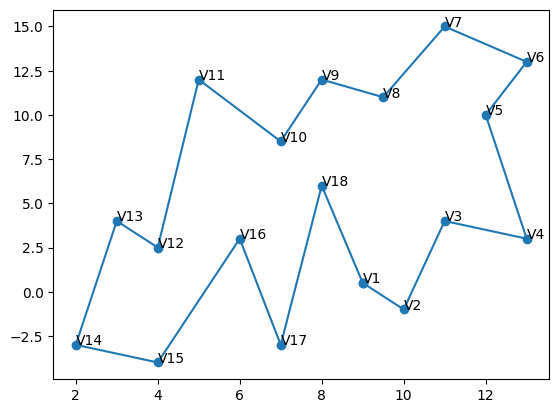

In [861]:
grafic(DCEL1.list_vertex)

**2. Implement an algorithm able to split the given polygon in to y-monotone polygons. Give your answer in terms of doubly-connected edge lists. Plot your result.**

- This functions help to find the vertex type:

In [862]:
def neighbors(v):
    e = v.edge_inci # Tomamos la arista incidente
    e_prev = e.prev #Tomamos la semi-arista previa
    e_next = e.next #Tomamos la semi-arista next
    v1 = e_prev.origin #Tomamos el vertice que da origen a la semi-arista prev
    v2 = e_next.origin # Tomamos el vetice final de la semi arista next
    pos1 = v.r_order_binary(v1) #Vemos la posicion de v1 con respecto a v
    pos2 = v.r_order_binary(v2) #Vemos la posicion de V2 con respecto a v
    if pos1 != pos2:
        #print('uno arriba y otro abajo')
        return 1 #Esta uno arriba y otro abajo
    else:
        if pos1 == 1 and pos2 == 1:
            #print('Ambos estan arriba')
            return 2 #Ambos estan abajo
        elif pos1 == 0 and pos2 == 0:
            #print('Ambos estan abajo')
            return 3 #Ambos estan abajo

In [863]:
def type_vertex(v): 
    pos = neighbors(v)
    #print(pos)
    #print(orientacion(v.edge_inci.origin,v.edge_inci.prev.origin,v.edge_inci.next.origin))
    if pos == 3: #Estan por debajo
        if orientacion(v.edge_inci.origin,v.edge_inci.prev.origin,v.edge_inci.next.origin): #TRUE - antihorario
            v.type = 'split'
        else: #False - horario
            v.type = 'start'
    elif pos == 2: #Estan por arriba
        if orientacion(v.edge_inci.origin,v.edge_inci.prev.origin,v.edge_inci.next.origin): #TRUE - antihorario
            v.type = 'merge'
        else: #False - horario
            v.type = 'end'
    else:
        v.type = 'regular'
    return v

In [864]:
def each_vertex(DCEL):
    for i in range(len(DCEL.list_vertex)):
        DCEL.list_vertex[i] = type_vertex(DCEL.list_vertex[i])
        for j in DCEL.list_edge: #Update vertex in list edge
            if j.origin.name == DCEL.list_vertex[i].name:
                j.origin = DCEL.list_vertex[i] 
    
    return DCEL

### Vizualize the type to each vertex

In [865]:
DCEL1 = each_vertex(DCEL1)

In [866]:
def grafic_typeVertex(P):
    xcor = []
    ycor = []
    for n in P:
        xcor.append(n.x)
        ycor.append(n.y)
    
    xcor.append(xcor[0])
    ycor.append(ycor[0])

    #plt.scatter(xcor,ycor)
    plt.plot(xcor,ycor)
    for n in P:
        plt.annotate(n.name, xy = (n.x, n.y), xytext=(n.x, n.y))
        if n.type == 'start': # Square
            plt.plot(n.x,n.y, "rs")
        elif n.type == 'split': # Triangle up
            plt.plot(n.x,n.y, "g^")
        elif n.type == 'end': #star
            plt.plot(n.x,n.y, "y*")
        elif n.type == 'merge': #Triangle down
            plt.plot(n.x,n.y, "bv")
        else: # Regular is a Diamond
            plt.plot(n.x,n.y, "kD")

    plt.show()

**Antes de empezar con el algoritmo de y-monotona, para cada vertice encontramos el tipo de vertice que es, el cual esta dado de la siguiente manera:**

- $\blacksquare$ Start Vertex
- $\blacktriangle$ Split Vertex
- $\bigstar$ End Vertex
- $\blacktriangledown$ Merge Vertex
- $\blacklozenge$ Regular Vertex

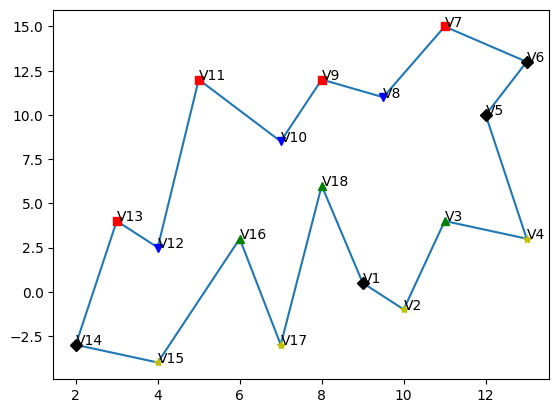

In [867]:
grafic_typeVertex(DCEL1.list_vertex)

- This fuction add a Diagonal to the polygon: 

In [868]:
def check_cycle(ea,eb):
    #print("check",ea.name)
    faces = ea.face
    #print(faces.name)
    eta = False
    etb = False
    e = 0
    if faces.name[0] =='I':
        e = faces.interior

    #print(e.name)
    #print(e.next.name)
    edge = e
    e = e.next
    #print("2",edge.name)
    #print("2",e.name)
    if (edge == eb) or (edge == ea):
        while(e != edge):
            #print("3",e.name)
            if (e == ea) or (e == eb):
                eta = True
                etb = True 
                e = e.next
            else:
                e = e.next
    else:
        while(e != edge):
            #print('2',e.name)
            if e == ea:
                eta = True 
                e = e.next
            elif e == eb:
                etb = True 
                e = e.next
            else:
                e = e.next

    #print(eta,etb)

    if eta == etb:
        if eta == True:
            return True
        else:
            return False
    else:
        return False 

In [869]:
#input: Vertex a, Vertex b and Doubly-connected edge list
#Output: Update Doubly-connected edge list
def add_diagonal(Va,Vb,DCEL):
    # take a K that i had used before.
    k = 0
    for i in DCEL.list_edge:
        if (i.name[0] == "e"):
            k += 1
    k = k+1

    #1. Origin(ek)=Va, Origin(tek)=Vb
    ek = half_edge(Va,Vb,'e'+str(k))
    tek = half_edge(Vb,Va,'te'+str(k))
    #2. Identify the half-edges that have Origin = Va and Origin = Vb and have the same incident face and 
    # are in the same cicle 
    ea = []
    eb = []
    ea1 = None
    eb1 = None
    for i in DCEL.list_edge:
        if(i.origin == Va)  :
            ea.append(i)
            # print("ea",i.name)
        elif(i.origin == Vb) :
            eb.append(i)
            # print("eb",i.name)

    if (len(ea)> 1) or (len(eb)> 1):
        #print('good')
        for i in ea:
            for j in eb:
                # print("facesName", i.face.name,j.face.name)
                if (i.face.name == j.face.name) and (i.face.name[0] != "E"):
                    # print("entro")
                    ea1 = i
                    eb1 = j
    else:
        ea1 = ea[0]
        eb1 = eb[0]

    # print("precheck","ea:",ea1.name,"eb:",eb1.name)


    if check_cycle(ea1,eb1): #Update
        # Prev(ek) = Prev(ea),Prev(tek) = Prev(eb) 
        ek.add_prev(ea1.prev)
        tek.add_prev(eb1.prev) 
        # Next(ek) = eb, Next(tek)= ea 
        ek.add_next(eb1)
        tek.add_next(ea1)
        # Update Twins
        #print(ek)
        ek.add_twin_save(tek)
        tek.add_twin_save(ek)
        # Next(Prev(ea)) = ek, Next(Prev(eb)) = tek 
        for i in DCEL.list_edge:
            if (i.origin == ea1.prev.origin) and (i.face.name == ea1.face.name):
                 i.add_next(ek)
            elif (i.origin == eb1.prev.origin) and (i.face.name == eb1.face.name):
                i.add_next(tek)
        #prev(ea) = tek and prev(eb) = ek
        ea1.add_prev(tek) 
        eb1.add_prev(ek) 
        #UpDate List Edge, Add edge ek and tek
        for i in DCEL.list_edge:
            if i.origin == ea1.origin:
                i = ea1
            elif i.origin == eb1.origin:
                i = eb1



        DCEL.list_edge.append(ek)
        DCEL.list_edge.append(tek)
    
        #UpDate List of Faces
        # Delete Face incidente of ea and eb
        copy = DCEL.list_face.copy()
        for i in copy:
            if i.name == ea1.face.name:
                index = DCEL.list_face.index(i)
        
        DCEL.list_face.pop(index)
        
        I1,I2= face('I1'+str(k)),face('I2'+str(k))
        I1.interior = ek
        I2.interior = tek
        DCEL.cicle(ek,I1)
        DCEL.cicle(tek,I2)

        DCEL.list_face.append(I1)
        DCEL.list_face.append(I2)
        #print_edge(DCEL)

    else:
        print('No comparten una misma cara')
    
    return DCEL

## Lista de Eventos

In [870]:
# The queue Events
class queue_Events:
    def __init__(self,vertex):
        self.point = vertex
        self.left = None
        self.right = None
    
def Insert_Sort_Event(raiz,punto):
    if(raiz.point.y < punto.point.y):
        if raiz.left is None:
            raiz.left = punto
        else:
            Insert_Sort_Event(raiz.left,punto)
    elif(raiz.point.y == punto.point.y):
        if(raiz.point.x > punto.point.x):
            if raiz.left is None:
                raiz.left = punto
            else:
                Insert_Sort_Event(raiz.left,punto)
        else:
            if raiz.right is None:
                raiz.right = punto
            else:
                Insert_Sort_Event(raiz.right,punto)
    else:
        if raiz.right is None:
                raiz.right = punto
        else:
            Insert_Sort_Event(raiz.right,punto)

In [871]:
#Sorted the list Q
def inorder_queue(root):
    inorderArr = []
    if root.left is not None:
        leftInorderArr = inorder_queue(root.left)
        inorderArr.extend(leftInorderArr) #Toma el arreglo y los agrega como elementos y no un arreglo de arreglos
    
    inorderArr.append(root)
    if root.right is not None:
        rightInorderArr = inorder_queue(root.right)
        inorderArr.extend(rightInorderArr) #Toma el arreglo y los agrega como elementos y no un arreglo de arreglos
    
    return inorderArr

## Tree Binary
It have only the ej that is more right

In [872]:
def Croos_line(vi, S):
    Alpha = (vi.y - S.edg.queue.y)/ (S.edg.origin.y- S.edg.queue.y)
    x = (Alpha* S.edg.origin.x)+((1-Alpha)*S.edg.queue.x)
    Pc = vertex(x,vi.y,"Vmid")
    return Pc

In [873]:
class node:
    def __init__(self,ei):
        self.value = ei.origin
        self.edg = ei
        self.left= None
        self.right = None

#Add Node to tree binary
def add_node(root, ei):
    if root == None:
        root = ei
    else:
        if ei.edg.origin.x < root.edg.origin.x:
            if root.right is None:
                root.right = ei
            else:
                add_node(root.right, ei)
        else:
            if root.left is None:
                root.left = ei
            else:
                add_node(root.left, ei)
    return root

#Search edge in the tree bynary
def search(ei, node):
    if node.value.name == ei.origin.name:
        return node
        
    if ei.origin.x < node.value.origin.x:
        if node.right:
            return search(ei, node.right)
        else:
             return None
    else:
        if node.left:
            return search(ei,node.left)
        else:
            return None
        
#Delete of tree binary
def delete(node,ei):
    if not node:
        return None
    else:
        if ei.origin.x < node.value.x:
            node.right = delete(node.right,ei)
        elif ei.origin.x > node.value.x:
            node.left = delete(node.left,ei)
        else:
            if not node.right and not node.left:
                node = None
            elif not node.right:
                node = node.left
            elif not node.left:
                node = node.right
            else:
                new = search(ei, node)
                node= new
                node.right = delete(node.right,new.edg)  
    return node  

#search for the one closest to Vi
def elemnts(root):
    cand = []
    if root.left is not None:
        leftArr = elemnts(root.left)
        cand.extend(leftArr) 
    
    cand.append(root)
    if root.right is not None:
        rightArr = elemnts(root.right)
        cand.extend(rightArr) 
    
    return cand

            
def left_closest_vi(node,vi):
    cand = elemnts(node)
    node_left = None
    l_cand = []
    for i in cand:
        #print(orientacion(vi,i.edg.origin,i.edg.next.origin))
        if orientacion(vi,i.edg.origin,i.edg.next.origin):
            #print(i.value.name)
            l_cand.append(i)

    #print("one")
    #print('0',l_cand[0].edg.name)
    node_left = l_cand[0]
            


    return node_left
    

#Updat helper (root,value_older, value_new)
def update( root,node):
    if root == None:
        return None
    
    if root.edg.name == node.edg.name:
       root.edg.update_helper(node.edg.helper)
        
    if root.value.x > node.value.x:
        if root.right:
            return update(root.right,node)
    else:
        if root.left:
            return update(root.left,node)

def print_tree(node, level=0):
    if node is not None:
        print_tree(node.right, level + 1)
        print('   ' * level + '->', node.edg.name)
        print_tree(node.left, level + 1)


In [874]:
#input: ei origin of edge, DCEL, vi helper
# output: update helper edge with origin in vi
def update_helper_edge(ei,vi,LP):
    for i in LP.list_edge:
        if i.name == ei.name:
            i.update_helper(vi)
    
    return LP

In [875]:
def search_edge(ei,LP):
    ej = None
    for i in LP.list_edge:
        if i.name == ei.name:
            ej = i
    return ej
    

# Algorithm Y-monotone (P)
We have to do by polynomial P in Y-monotone

In [876]:
def handle_start(T,vi,LP):
    # Add ei to Tao and helper(ei) = vi
    vi.edge_inci.update_helper(vi)
    LP = update_helper_edge(vi.edge_inci,vi,LP)
    if T == None:
        T = node(vi.edge_inci)
    else:
        T = add_node(T,node(vi.edge_inci))
    return T, LP

In [877]:
def handle_end(T,vi,LP):
    e_i_1 = search_edge(vi.edge_inci.prev,LP)
    if e_i_1.helper.type == "merge":
        #print("Diagonale en:", e_i_1.helper.name,vi.name)
        LP = add_diagonal(vi,e_i_1.helper,LP)
    #print("--*Delete")
    #print(e_i_1.name)
    T = delete(T,e_i_1)
    #print_tree(T, level=0)
    return T,LP
   

In [878]:
def handle_split(T,vi,LP):
    #print("6*.Diagonal")
    #print("left")
    N = left_closest_vi(T,vi)
    #print(N.edg.name, N.edg.helper.name)
    #print_tree(T, level=0) 
    #print("-------------")
    #print("Diagonale en:", N.edg.helper.name,vi.name)
    LP = add_diagonal(vi,N.edg.helper,LP)
    N.edg.update_helper(vi)
    LP = update_helper_edge(N.edg,vi,LP)
    #print("*update")
    #print(N.edg.name, N.edg.helper.name)
    update(T,N)  
    #print_tree(T, level=0) 
    #print("-------------")
    #print("add")
    vi.edge_inci.update_helper(vi)
    LP = update_helper_edge(vi.edge_inci,vi,LP)
    #print(vi.edge_inci.name, vi.edge_inci.helper.name)
    T = add_node(T,node(vi.edge_inci))
    #print_tree(T, level=0)
    return T,LP
    

    

In [879]:
def handle_merge(T,vi,LP):
    e_i_1 = search_edge(vi.edge_inci.prev,LP)
    if e_i_1.helper.type == "merge":
        #print("5.Diagonal")
        #print("Diagonale en:", e_i_1.helper.name,vi.name)
        LP = add_diagonal(vi,e_i_1.helper,LP)
    #print("*Delete")
    #print(e_i_1.name)
    T = delete(T,e_i_1)
    #print_tree(T, level=0)
    #print("-------------")
    #print("left")
    N = left_closest_vi(T,vi)
    #print(N.edg.name)
    if N.edg.helper.type == "merge":
        #print("4.Diagonal")
        #print("Diagonale en:", N.edg.helper.name,vi.name)
        LP = add_diagonal(vi,N.edg.helper,LP)
    N.edg.update_helper(vi)  
    LP = update_helper_edge(N.edg,vi,LP)
    #print("*update")
    #print(N.edg.name, N.edg.helper.name)
    update(T,N) 
    #print_tree(T, level=0) 
    #print("-------------")
    return T,LP


In [880]:
def handle_regular(T,vi,LP):
    # Take ei-1
    e_i_1 = search_edge(vi.edge_inci.prev,LP)
    #the interior of P lies to the right of vi
    #we check if the y-coordinate is decreasing
    if vi.y < e_i_1.origin.y:
        #if helper(ei-1) is merge
        if e_i_1.helper.type == "merge":
            #print("1.Diagonal")
            #print("Diagonale en:", e_i_1.helper.name,vi.name)
            LP = add_diagonal(vi,e_i_1.helper,LP)
        #print("Delete")
        #print(e_i_1.name)
        T = delete(T,e_i_1)
        #print_tree(T, level=0)
        #print("add")
        #print(vi.edge_inci.name, e_i_1.helper.name)
        vi.edge_inci.update_helper(vi)
        LP =update_helper_edge(vi.edge_inci,vi,LP)
        T = add_node(T,node(vi.edge_inci))
    else:
        #print("left")
        N = left_closest_vi(T,vi)
        #print(N.edg.helper.type)
        #print(N.edg.name)
        if N.edg.helper.type == "merge":
           #print("2.Diagonal")
           #print("Diagonale en:", N.edg.helper.name,vi.name)
           LP = add_diagonal(vi,N.edg.helper,LP)
        N.edg.update_helper(vi)  
        LP = update_helper_edge(N.edg,vi,LP)
        #print("update")
        #print(N.edg.name,N.edg.helper.name) 
        update(T,N) 
        #print_tree(T, level=0) 
    
    return T,LP
    


In [881]:
#Input: list DCEL of a polynomial simple P
#Output: Update DCEL with subsivision y-monotone
def y_monotone(LP):
    #Create Queue Events
    Q = []
    root = queue_Events(LP.list_vertex[0])
    for i in range(1,len(LP.list_vertex)):
        Insert_Sort_Event(root,queue_Events(LP.list_vertex[i]))
    Q = inorder_queue(root)
    
    # initialize tree binary
    T = None
    # While Q is not empty
    while(len(Q) != 0):
        vi = Q[0].point
        Q.pop(0)
        #handle vertex Vi
        if vi.type == "start":
            T,LP = handle_start(T,vi,LP)
        elif vi.type == "split":
            T,LP = handle_split(T,vi,LP)
        elif vi.type == "merge":
            T,LP = handle_merge(T,vi,LP)
        elif vi.type == "end":
            T,LP = handle_end(T,vi,LP)
        else:
            T,LP = handle_regular(T,vi,LP)
        #print_tree(T, level=0)
        #print("-----------------------")
    return LP
    

In [882]:
def graphic_y_monotone(DCEL1):
    P = DCEL1.list_vertex
    
    xcor = []
    ycor = []
    for i in DCEL1.list_edge:
        if(i.name[0] == 'e'):
            if (int(float(i.name[1:])) < 18) :
                xcor.append(i.origin.x)
                ycor.append(i.origin.y)
            elif (int(float(i.name[1:])) == 18):
                
                xcor.append(i.origin.x)
                ycor.append(i.origin.y)
                xcor.append(i.queue.x)
                ycor.append(i.queue.y)

            else: 
                plt.plot(xcor,ycor)
                xcor = []
                ycor = []
                xcor.append(i.origin.x)
                ycor.append(i.origin.y)
                xcor.append(i.queue.x)
                ycor.append(i.queue.y)

    plt.plot(xcor,ycor)
    #plot faces
    for n in P:
        plt.annotate(n.name, xy = (n.x, n.y), xytext=(n.x, n.y))
        if n.type == 'start': # Square
            plt.plot(n.x,n.y, "rs")
        elif n.type == 'split': # Triangle up
            plt.plot(n.x,n.y, "g^")
        elif n.type == 'end': #star
            plt.plot(n.x,n.y, "y*")
        elif n.type == 'merge': #Triangle down
            plt.plot(n.x,n.y, "bv")
        else: # Regular is a Diamond
            plt.plot(n.x,n.y, "kD")

plt.show()


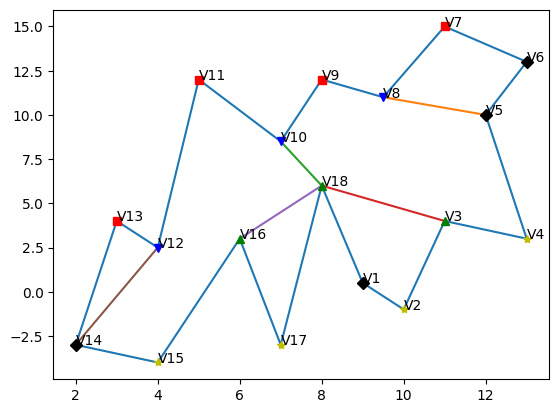

In [883]:
DCEL1 = y_monotone(DCEL1)
graphic_y_monotone(DCEL1)

**3.Implement the triangulation procedure and apply it to each y-monotone
polygon. Give your answer in terms of a doubly-connected edge list. Plot your result.**

In [884]:
def sibdivision(face):
    vertecies = []
    edge = face.interior
    # Sorted by relation order
    root = queue_Events(face.interior.origin)
    e = face.interior.next
    while(e!=edge):
        Insert_Sort_Event(root,queue_Events(e.origin))
        e = e.next
    vertecies = inorder_queue(root)
    return vertecies
    

In [885]:
def search_edge2(v,face,LP):
    ej = None
    for i in LP.list_edge:
        if (i.origin.name == v.name) and (i.face.name == face.name):
            # print(i.name)
            ej = i
    return ej

In [886]:
def chain(v,face,LP):
    # Tag is 1 left and 0 right, 2 top, 3 bottom
    top = v[0]
    e_top = search_edge2(top.point,face,LP)
    bottom = v[-1]
    e_bottom = search_edge2(bottom.point,face,LP)
    # Left
    cop_top = e_top.next
    while(cop_top.name != e_bottom.name):
        for i in v:
            if cop_top.origin.name == i.point.name:
                i.point.chain = 1
        cop_top = cop_top.next
    #right
    cop_bottom = e_bottom.next
    while(cop_bottom.name != e_top.name):
        for i in v:
            if cop_bottom.origin.name == i.point.name:
                i.point.chain = 0
        cop_bottom = cop_bottom.next

    v[0].point.chain = v[1].point.chain
    v[-1].point.chain = v[-2].point.chain       

    return v

In [887]:
def check_chain(v1,v2):
    if v1.chain == v2.chain:
        # print("Same chain")
        return True
    else:
        # print("different chain")
        return False
    

In [888]:
# last v2
# S-1 v1
# stacki v3
def check_diagonal(v1,v2,v3):
    if v1.x < v2.x and  v3.x < v2.x:
        return True
    elif v1.x > v2.x and  v3.x > v2.x:
        return True
    else: return False



In [889]:
def triangulation_polygon(t,DCEL2):
    S = []
    #print(t.name)
    #Vertex sorted by relation order <
    stack1 = sibdivision(t)
    stack1 = chain(stack1,t,DCEL2)
    # for i in stack1:
    #     print(i.point.name, i.point.chain)

    # Start Algoritm
    S.append(stack1[0])
    S.append(stack1[1])
    
    for i in range(2,len(stack1)-1):
        #print(S[-1].point.name,stack1[i].point.name)
        #print(check_chain(S[-1].point,stack1[i].point))
        S1 = S.copy()
        ## Case1: Different chain
        if check_chain(S[-1].point,stack1[i].point) != True:
            while(len(S) != 0):
                if len(S) == 1:
                    S.pop(-1)
                    #add_diagonal(pop_vertex.point,stack1[i].point)
                else:
                    pop_vertex = S[-1]
                    S.pop(-1)
                    DCEL2 = add_diagonal(pop_vertex.point,stack1[i].point, DCEL2)
            S.append(stack1[i-1])
            S.append(stack1[i])
        #Case 2: Same Chain
        else:
            #Pop one vertex from S.
            last = S[-1]
            S.pop(-1)
            S1.pop(-1)
            while(len(S1) != 0):
                # print('last:',last.point.name,'S-1',S1[-1].point.name,'Stacki',stack1[i].point.name)
                # print('or',orientacion(last.point,stack1[i].point,S1[-1].point))
                # print('check',check_chain(S1[-1].point,stack1[i].point))
                # print(".-")
                if orientacion(last.point,stack1[i].point,S1[-1].point) and check_chain(S1[-1].point,stack1[i].point) != True:
                    #print("2Diagonal",S1[-1].point.name,stack1[i].point.name)
                    DCEL2 = add_diagonal(S1[-1].point,stack1[i].point, DCEL2)
                    idex = S.index(S1[-1])
                    last = S[idex]
                    S.pop(idex)
                    S1.pop(-1)
                elif check_chain(S1[-1].point,stack1[i].point) and orientacion(last.point,stack1[i].point,S1[-1].point) != True:
                    if check_diagonal(S1[-1].point,last.point,stack1[i].point):
                        # print(S1[-1].point.name,stack1[i].point.name)
                        # print("3Diagonal",S1[-1].point.name,stack1[i].point.name)
                        DCEL2 = add_diagonal(S1[-1].point,stack1[i].point, DCEL2)
                        idex = S.index(S1[-1])
                        last = S[idex]
                        S.pop(idex)
                    S1.pop(-1)
                    
                else:
                    # print("no se elimina de S",S1[-1].point.name)
                    S1.pop(-1)
            S.append(last)
            S.append(stack1[i])

    if len(S) > 2:
        for i in range(1,len(S)-1):
            DCEL2 = add_diagonal(S[i].point,stack1[-1].point, DCEL2)
            # print("Diagonal",S[i].point.name,stack1[-1].point.name)
    
    #graphic_y_monotone(DCEL2)
    return DCEL2

In [890]:
def triangulation_polygon_all(DCEL):
    N_faces = len(DCEL.list_face)
    copias = DCEL.list_face.copy()
    #print(copias)
    # print(N_faces)
    for i in range(1,N_faces):
        t = copias[i]
        #print(t.name)
        DCEL = triangulation_polygon(t,DCEL)

    graphic_y_monotone(DCEL)
    
    

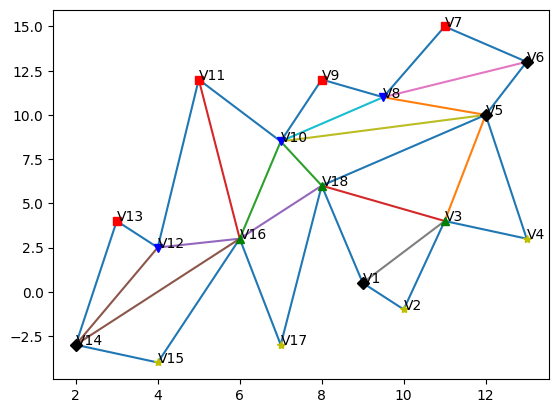

In [891]:
DCEL3 = DCEL1
triangulation_polygon_all(DCEL1)